> # **Environment Sound Detection with ESC Dataset**

## **Importing essential libraries and frameworks**

In [1]:
import os
import librosa
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import Audio

In [2]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## **Preprocessing**:

### We used the ESC50 dataset but obtained a subset of that and actually trained our models on ESC10.

In [3]:
root_dir = '/kaggle/input/hda-audio/ESC-50'

dataset_path = root_dir + '/audio'
meta_path = root_dir + '/esc50.csv'

meta_df = pd.read_csv(meta_path)

In [4]:
def load_audio_and_label(path):
    files = os.listdir(path)[:3]
    waveforms = []
    labels = []
    for file in files:
        waveform, _ = librosa.load(path + '/' + file, sr=None)
        label = meta_df.loc[meta_df['filename'] == file, 'category'].values
        waveforms.append(waveform)
        labels.append(label)
    return waveforms, labels


def plot_wave(waveform, label):
    plt.figure(figsize=(12,12))
    plot = plt.subplot(211)
    plot.plot(waveform)
    plot.set_xlabel('Sample Rate * Time')
    plot.set_ylabel('Values')
    plt.title('LABEL: ' + label)
    plt.show()
    return

### We randomly pick 3 audio files convert them to waves and plot them with their labels.

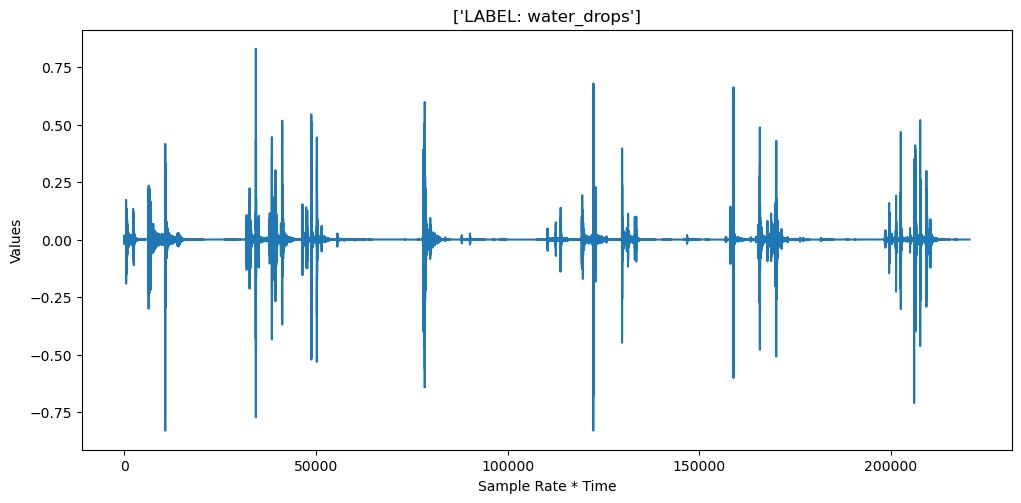

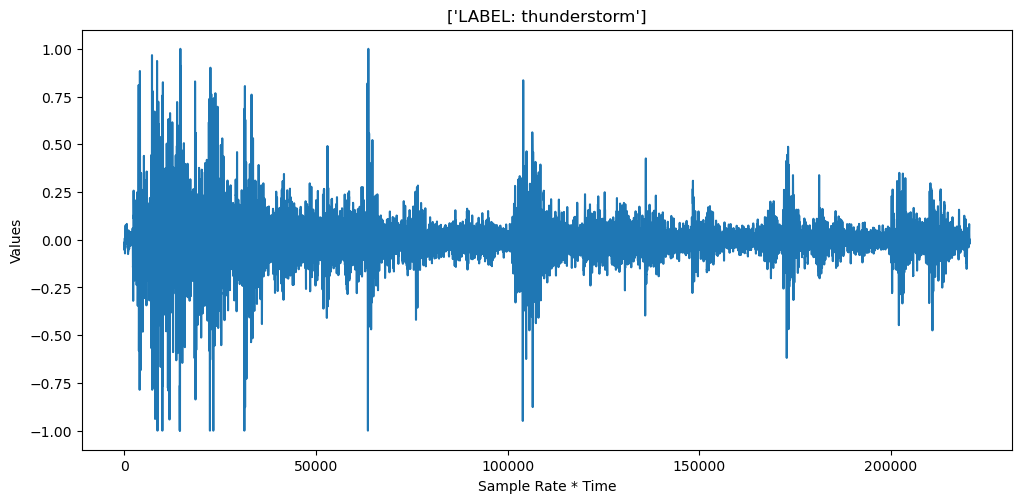

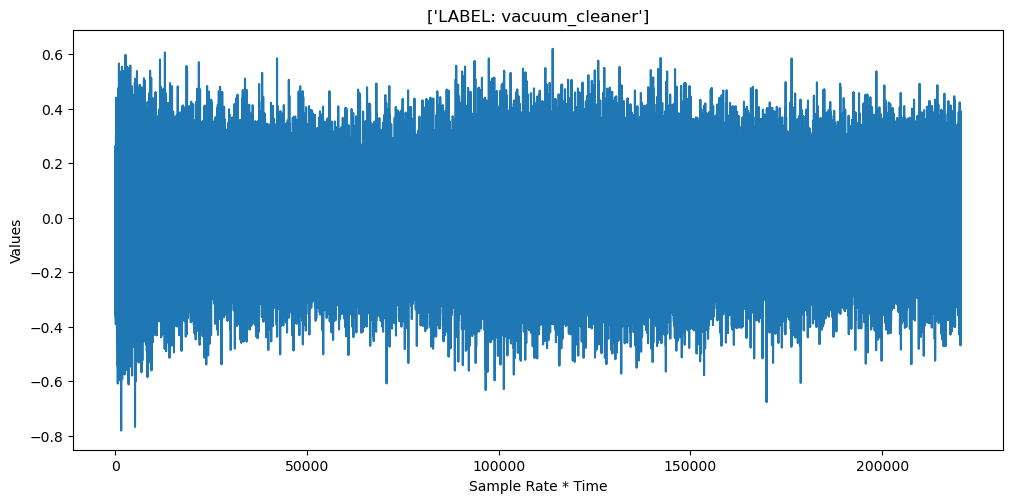

In [5]:
waveforms, labels = load_audio_and_label(dataset_path)

for i in range(3):
    plot_wave(waveforms[i], labels[i])

In [6]:
print(labels[0])
Audio(waveforms[0], rate=44100)

['water_drops']


In [7]:
print(labels[1])
Audio(waveforms[1], rate=44100)

['thunderstorm']


In [8]:
print(labels[2])
Audio(waveforms[2], rate=44100)

['vacuum_cleaner']


### With this subset, we have 400 environmental sound and 10 output classes of which 5 percent and 10 percent are dedicated to the testing set and validation set, respectively.
### So we have 342 training data, 38 validation data, and 20 test data.

In [9]:
def create_dataset_dataframe(df):
    df_filtered = df[df['esc10'] == True]
    categories = df_filtered['category'].values
    label_mapping = {
        'chainsaw': 0,
        'clock_tick': 1,
        'crackling_fire': 2,
        'crying_baby': 3,
        'dog': 4,
        'helicopter': 5,
        'rain': 6,
        'rooster': 7,
        'sea_waves': 8,
        'sneezing': 9
    }
    targets = []
    for category in categories:
        targets.append(label_mapping[category])
    filenames = df_filtered['filename'].values
    new_filenames = [dataset_path + '/' + filename for filename in filenames]
    return pd.DataFrame({'filename': new_filenames, 'target': targets, 'category': categories})


def one_hot_label_encoder(df):
    return  OneHotEncoder().fit_transform(df['target'].values.reshape(-1, 1)).toarray()

In [10]:
dataset_dataframe = create_dataset_dataframe(meta_df)

labels = one_hot_label_encoder(dataset_dataframe)

In [11]:
def dataset_splitter(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data['filename'].values, labels, test_size=0.05, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    return X_train.reshape(len(X_train),), y_train, X_val.reshape(len(X_val),), y_val, X_test.reshape(len(X_test),), y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = dataset_splitter(dataset_dataframe, labels)

### The batch size for creating a dataset is 16 and the default sample rate of the audio files was 44100H, which we changed to 16000H.

In [13]:
batch_size = 16
RATE = 16000

### We create the dataset with Four steps:
1. We convert audio files to waveforms (signals)
2. Then we convert the waveforms to log mel spectrogram. The spectrograms are heatmap images of signals. The key point is with spectrograms we can use CNN-based models for training our networks
3. We use time delay as our augmentation technique to add some delays randomly to our training set
4. Finally we normalize the value of the image tensors to be in the range of 0 to 255

In [14]:
# def audio_generator(file_names, labels):
#     for file_name, label in zip(file_names, labels):
#         waveform, _ = tf.audio.decode_wav(tf.io.read_file(file_name))
#         yield waveform, label

In [15]:
def audio_to_waveform(audio, label):
    waveform, _ = tf.audio.decode_wav(tf.io.read_file(audio))
    waveform = tfio.audio.resample(waveform, rate_in=44100, rate_out=RATE)
    waveform = tf.squeeze(waveform, axis=-1)
    waveform = tf.cast(waveform, tf.float32)
    return waveform, label

def waveform_to_log_mel_spectrogram(waveform, label):
    # Compute the short-time Fourier transform (STFT) of the waveform
    fl = 4096
    stft = tf.signal.stft(waveform, frame_length=fl, frame_step=256, fft_length=fl)
    # Convert the STFT to a magnitude spectrogram
    magnitude_spectrogram = tf.abs(stft)
    # Create a mel filterbank and apply it to the magnitude spectrogram
    num_fft_bins = fl // 2 + 1
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(256, num_fft_bins, RATE, lower_edge_hertz=20, upper_edge_hertz=RATE // 2)
    mel_spectrogram = tf.matmul(tf.square(magnitude_spectrogram), mel_filterbank)
    # Convert the mel spectrogram to a log-scaled mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # Convert it to 3D tensor
    log_mel_spectrogram = tf.ensure_shape(tf.expand_dims(log_mel_spectrogram, axis=-1), [None, None, 1])
#    # Resize
    log_mel_spectrogram = tf.image.resize(log_mel_spectrogram, [256, 256], preserve_aspect_ratio=False)
    return log_mel_spectrogram, label

def add_time_delays(log_mel_spectrogram, label):
    time_shift = tf.random.uniform(shape=[], minval=-1, maxval=1, dtype=tf.float32)
    time_shift_samples = tf.cast(time_shift * RATE, dtype=tf.int32)
    log_mel_spectrogram = tf.roll(log_mel_spectrogram, time_shift_samples, axis=0)
    return log_mel_spectrogram, label

def normalizer(log_mel_spectrogram, label):
    max_val = tf.math.reduce_max(log_mel_spectrogram)
    min_val = tf.math.reduce_min(log_mel_spectrogram)
    return (log_mel_spectrogram - min_val) / (max_val - min_val), label

In [16]:
def create_dataset(filenames, labels, aug_fun, shuffle, cache, repeat=False):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(audio_to_waveform, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(waveform_to_log_mel_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if aug_fun is not None:
        dataset = dataset.map(aug_fun, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(normalizer, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache(cache)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(filenames))
    if repeat:    
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# def create_dataset(filenames, labels, aug_fun, shuffle, cache, repeat=False):
#     dataset = tf.data.Dataset.from_generator(
#         audio_generator,
#         args=[filenames, labels],
#         output_signature=(tf.TensorSpec(shape=(None, None), dtype=tf.float32), tf.TensorSpec(shape=(50,), dtype=tf.float32))
#     )
#     dataset = dataset.map(audio_to_waveform, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.map(waveform_to_log_mel_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
#     if aug_fun is not None:
#         dataset = dataset.map(aug_fun, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.map(normalizer, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.cache(cache)
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=len(filenames))
#     if repeat:    
#         dataset = dataset.repeat()    
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.AUTOTUNE)
#     return dataset

In [17]:
train_dataset = create_dataset(X_train, y_train, aug_fun=add_time_delays, shuffle=True, cache='train', repeat=True)

validation_dataset = create_dataset(X_val, y_val, aug_fun=None, shuffle=False, cache='validation')

test_dataset = create_dataset(X_test, y_test, aug_fun=None, shuffle=False, cache='test')

### Here we defined some functions to plot the log mel spectrogram with the respective label.

In [18]:
def plot_mel_spectrogram(spectrogram, label):
    plt.imshow(spectrogram)
    plt.title("LABEL: " + label)
    plt.show()
    return
    
def label_decoder(encoded_labels):
    encoded_labels = encoded_labels.numpy()
    decoded_label = np.argmax(encoded_labels)
    return dataset_dataframe.loc[dataset_dataframe['target'] == decoded_label, 'category'].values[0]

In [19]:
train_sample = train_dataset.take(1).get_single_element()

val_sample = validation_dataset.take(1).get_single_element()

test_sample = test_dataset.take(1).get_single_element()

In [20]:
index = np.random.randint(0, batch_size, (1,))[0]

In [21]:
spectrogram = train_sample[0][index].numpy()
label = label_decoder(train_sample[1][index])

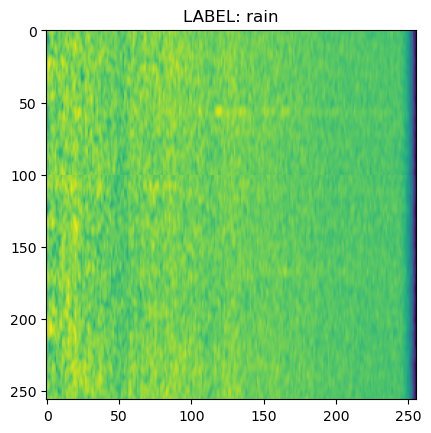

In [22]:
plot_mel_spectrogram(spectrogram, label)

In [23]:
spectrogram = val_sample[0][index].numpy()
label = label_decoder(val_sample[1][index])

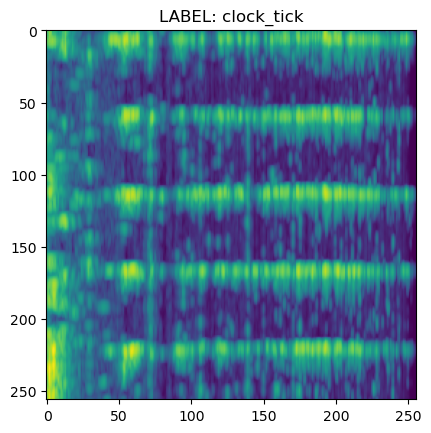

In [24]:
plot_mel_spectrogram(spectrogram, label)

In [25]:
spectrogram = test_sample[0][index].numpy()
label = label_decoder(test_sample[1][index])

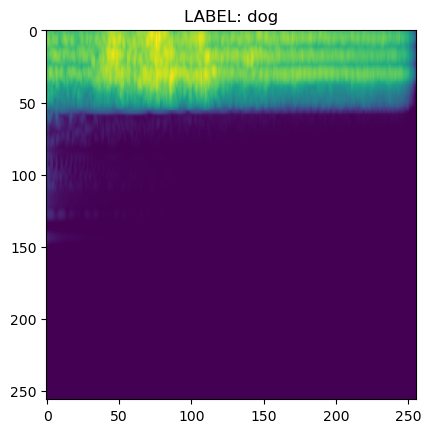

In [26]:
plot_mel_spectrogram(spectrogram, label)

### we define train, validation and test steps here.

In [27]:
train_steps = int(np.ceil(len(X_train) / batch_size))

val_steps = int(np.ceil(len(X_val) / batch_size))

test_steps = int(np.ceil(len(X_test) / batch_size))

### Here we defined some functions to plot metric curves, confusion matrix heatmap and also calculate f1 score.

In [28]:
def plot_loss_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    return

def plot_accuracy_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    return

def plot_confusion_matrix(model, dataset):
    classes = meta_df[meta_df['esc10'] == True]['category'].unique()
    y_test_preds = model.predict(dataset, steps=test_steps)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in dataset], axis=0)
    y_test = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test, y_test_preds, labels=[i for i in range(10)])
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

### Here we defined a custom Early Stopping class to stop training if we reached a specific threshold after a specific patient.

In [29]:
 class EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor, threshold, max_epochs, patience=3):
        super(EarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.best_weights = None
        self.max_epochs = max_epochs
        self.best_monitoring_value = float('-inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_monitoring_value = logs.get(self.monitor)
        if current_monitoring_value is None:
            raise ValueError(f"The metric {self.monitor} is not available in logs for early stopping.")
        if epoch >= self.max_epochs - 1:
            print(f"\n--- Early stopping: Reached maximum number of epochs : {self.max_epochs} \n")
            self.model.set_weights(self.best_weights)
            self.model.stop_training = True
            return
        if current_monitoring_value > self.best_monitoring_value:
            self.best_weights = self.model.get_weights()
            self.best_monitoring_value = current_monitoring_value
        if current_monitoring_value < self.threshold:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True
                print(f"\n--- Early stopping: {self.monitor} has been more than {self.threshold} for {self.patience} epochs.\n")
                return

> # Defining our CNN models

## EnsembleStackedCNN

### In this approach, we implement the EnsembleStackedCNN from scratch for the classification task.

### We consider the following points:

* All hidden layers use ReLu as their activation function
* The final layer uses Softmax as its activation function
* The Adam optimizer is used to minimize the gradient
* The Categorical Crossentropy is used for the loss function
* The Accuracy metric is used to evaluate model performance

In [30]:
def EnsembleStackedCNN(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(24, (6,6), strides=(1,1), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(24, (6,6), strides=(1,1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(48, (5,5), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(48, (5,5), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.85)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.models.Model(inputs=inputs, outputs=outputs, name='EnsembleStackedCNN-Classifier')

In [31]:
escnn = EnsembleStackedCNN(input_shape=spectrogram.shape)

In [32]:
escnn.summary()

Model: "EnsembleStackedCNN-Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 24)      888       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 24)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 24)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 24)      20760     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 24)     96        
 hNormalization)                     

In [33]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_escnn.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 80

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.8, max_epochs=MAX_EPOCHS, patience=2)

escnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [34]:
escnn_history = escnn.fit(train_dataset, epochs = MAX_EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/80
22/22 [==============================] - ETA: 0s - loss: 7.9311 - accuracy: 0.1733 - precision: 0.1883 - recall: 0.1278
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to best_escnn.h5
22/22 [==============================] - 15s 195ms/step - loss: 7.9311 - accuracy: 0.1733 - precision: 0.1883 - recall: 0.1278 - val_loss: 6.2359 - val_accuracy: 0.0938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/80
22/22 [==============================] - ETA: 0s - loss: 7.0685 - accuracy: 0.2841 - precision: 0.3034 - recall: 0.2017
Epoch 2: val_accuracy did not improve from 0.09375
22/22 [==============================] - 4s 172ms/step - loss: 7.0685 - accuracy: 0.2841 - precision: 0.3034 - recall: 0.2017 - val_loss: 6.2418 - val_accuracy: 0.0938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/80
22/22 [==============================] - ETA: 0s - loss: 6.4982 - accuracy: 0.3125 - precision: 0.3640 - recall: 0.2585
Epoch 3: val_accuracy did not 

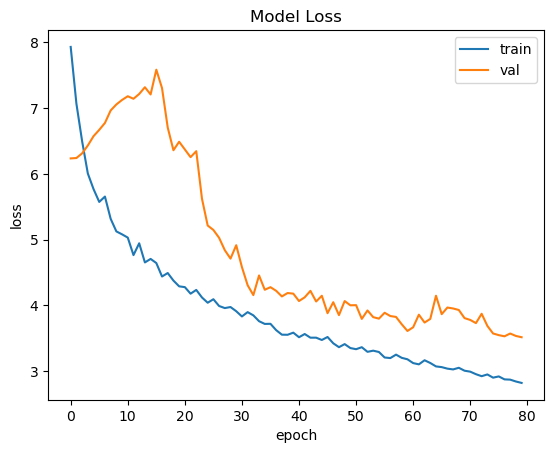

In [35]:
plot_loss_curve(escnn_history)

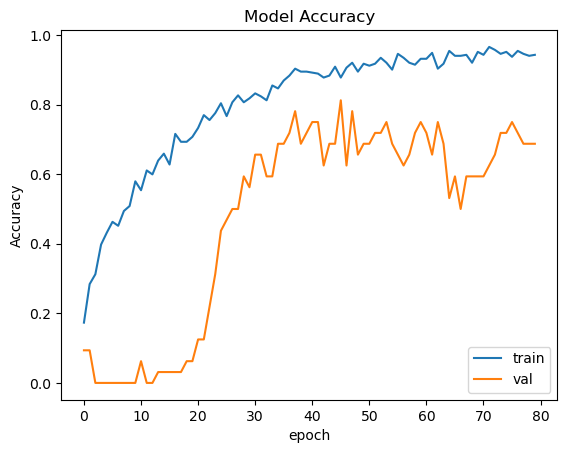

In [36]:
plot_accuracy_curve(escnn_history)

In [37]:
escnn_score = escnn.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("EnsembleStackedCNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(escnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(escnn_score[1]))
print('Testset Precision = {:.2f}'.format(escnn_score[2]))
print('Testset Recall = {:.2f}'.format(escnn_score[3]))

2/2 [==============================] - 1s 180ms/step - loss: 3.6444 - accuracy: 0.8000 - precision: 0.8889 - recall: 0.8000
EnsembleStackedCNN classifier evaluation results:

Testset Loss = 3.64438
Testset Accuracy = 0.80
Testset Precision = 0.89
Testset Recall = 0.80


2/2 [==============================] - 0s 17ms/step


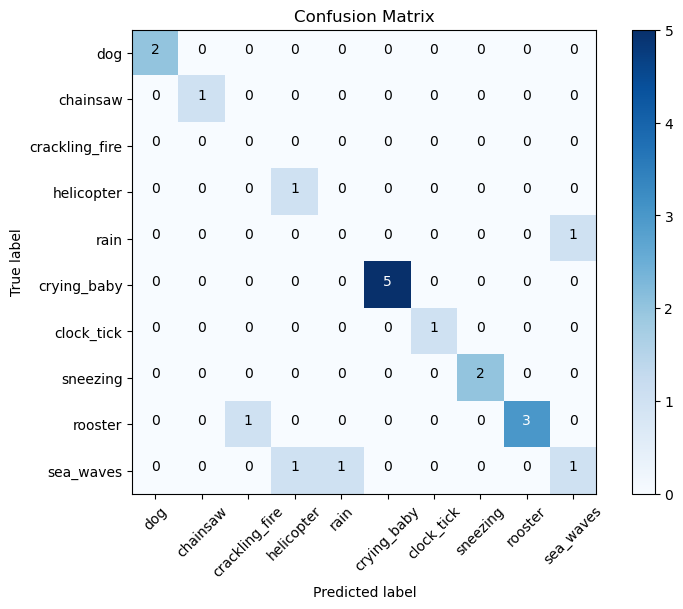

In [38]:
plot_confusion_matrix(escnn, test_dataset)

## InceptionV4

### In this approach, we implement the InceptionV4 from scratch for the classification task.

### We consider the following points:

* All hidden layers use ReLu as their activation function
* The final layer uses Softmax as its activation function
* The Adam optimizer is used to minimize the gradient
* The Categorical Crossentropy is used for the loss function
* The Accuracy metric is used to evaluate model performance

In [39]:
class InceptionV4:
    
    def __conv2d_with_batch(self, prev_layer, nbr_kernels, filter_size, strides=(1, 1), padding='valid'):
        X = tf.keras.layers.Conv2D(filters=nbr_kernels, kernel_size=filter_size, strides=strides, padding=padding)(prev_layer)
        X = tf.keras.layers.BatchNormalization()(X)
        return tf.keras.layers.Activation(activation='gelu')(X)

    def __stem_block(self, prev_layer):
        X = self.__conv2d_with_batch(prev_layer, nbr_kernels=32, filter_size=(3, 3), strides=(2, 2))
        X = self.__conv2d_with_batch(X, nbr_kernels=32, filter_size=(3, 3))
        X = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(3, 3))
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(3, 3), strides=(2, 2))
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=64, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(X_1, nbr_kernels=96, filter_size=(3, 3))
        X_2 = self.__conv2d_with_batch(X, nbr_kernels=96, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(X_2, nbr_kernels=96, filter_size=(3, 3))
        
        X = tf.keras.layers.concatenate([X_1, X_2], axis=3)
        
        X_1 = self.__conv2d_with_batch(X, nbr_kernels=192, filter_size=(3, 3), strides=2)
        
        X_2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(X)
        
        return tf.keras.layers.concatenate([X_1, X_2], axis=3)
    
    def __reduction_A_block(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(3, 3), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 3), strides=(2, 2))
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(3, 3), strides=(2, 2))
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    
    def __reduction_B_block(self, prev_layer):
        X_1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=192, filter_size=(3, 3), strides=(2, 2))
        X_3 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(7, 1), padding='same')
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=320, filter_size=(3, 3), strides=(2, 2))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3], axis=3)
    
    def __inception_block_A(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=96, filter_size=(3, 3), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=96, filter_size=(1, 1), padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=96, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_B(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=192, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=224, filter_size=(7, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=224, filter_size=(1, 7), padding='same')
        X_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(7, 1), padding='same')
        
        X_3 = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=128, filter_size=(1, 1))
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)

    def __inception_block_C(self, prev_layer):
        X_1 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=448, filter_size=(3, 1), padding='same')
        X_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=512, filter_size=(1, 3), padding='same')
        X_1_1 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_1_2 = self.__conv2d_with_batch(prev_layer=X_1, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_1 = tf.keras.layers.concatenate([X_1_1, X_1_2], axis=3)
        
        X_2 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
        X_2_1 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(1, 3), padding='same')
        X_2_2 = self.__conv2d_with_batch(prev_layer=X_2, nbr_kernels=256, filter_size=(3, 1), padding='same')
        
        X_2 = tf.keras.layers.concatenate([X_2_1, X_2_2], axis=3)
        
        X_3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
        
        X_3 = self.__conv2d_with_batch(prev_layer=X_3, nbr_kernels=256, filter_size=3, padding='same')
        X_4 = self.__conv2d_with_batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
        
        return tf.keras.layers.concatenate([X_1, X_2, X_3, X_4], axis=3)
    
    def __InceptionV4(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)
        
        X = self.__stem_block(prev_layer=input_layer)
        
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        X = self.__inception_block_A(prev_layer=X)
        
        X = self.__reduction_A_block(prev_layer=X)
        
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        X = self.__inception_block_B(prev_layer=X)
        
        X = self.__reduction_B_block(prev_layer=X)
        
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        X = self.__inception_block_C(prev_layer=X)
        
        output = tf.keras.layers.GlobalAveragePooling2D()(X)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=output, name='InceptionV4')

    def create_model(self, input_shape):
        base_model = self.__InceptionV4(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dropout(rate=0.8)(fc)
        fc = tf.keras.layers.Dense(10, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='InceptionV4_Classifier')

In [40]:
inceptionv4 = InceptionV4().create_model(input_shape=spectrogram.shape)

In [41]:
inceptionv4.summary()

Model: "InceptionV4_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 127, 127, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 127, 127, 32  128        ['conv2d_5[0][0]']               
 rmalization)                   )                                            

In [42]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_inveptionv4.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 80

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.75, max_epochs=MAX_EPOCHS, patience=3)

inceptionv4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [43]:
inceptionv4_history = inceptionv4.fit(train_dataset, epochs = MAX_EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/80
22/22 [==============================] - ETA: 0s - loss: 2.7622 - accuracy: 0.1250 - precision_1: 0.1224 - recall_1: 0.0170
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to best_inveptionv4.h5
22/22 [==============================] - 133s 785ms/step - loss: 2.7622 - accuracy: 0.1250 - precision_1: 0.1224 - recall_1: 0.0170 - val_loss: 2.3091 - val_accuracy: 0.0625 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/80
22/22 [==============================] - ETA: 0s - loss: 2.7847 - accuracy: 0.1392 - precision_1: 0.1321 - recall_1: 0.0199
Epoch 2: val_accuracy did not improve from 0.06250
22/22 [==============================] - 9s 428ms/step - loss: 2.7847 - accuracy: 0.1392 - precision_1: 0.1321 - recall_1: 0.0199 - val_loss: 2.3251 - val_accuracy: 0.0625 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/80
22/22 [==============================] - ETA: 0s - loss: 2.5020 - accuracy: 0.1960 - precision_1: 0.3171 - recall_1: 0.

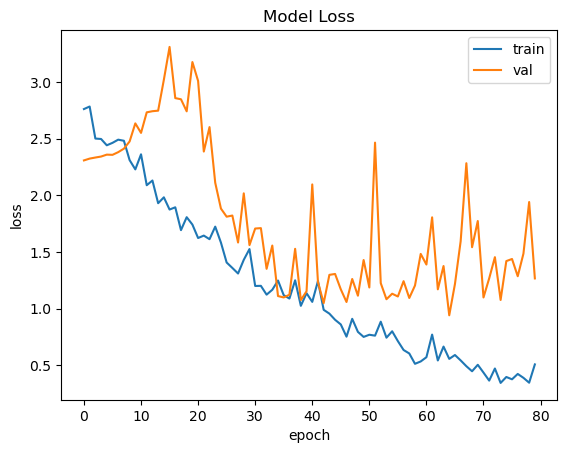

In [44]:
plot_loss_curve(inceptionv4_history)

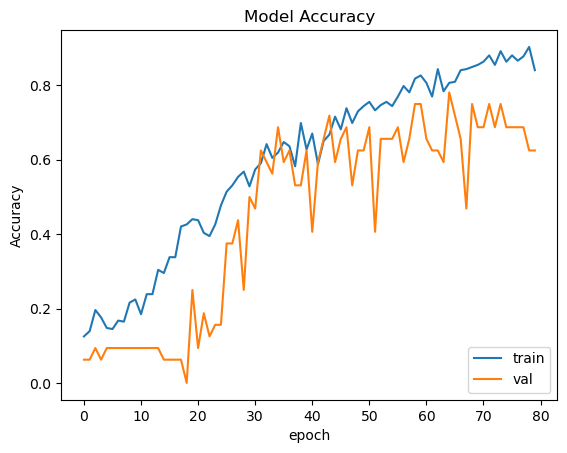

In [45]:
plot_accuracy_curve(inceptionv4_history)

In [46]:
inceptionv4_score = inceptionv4.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("InvecptionV4 classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(inceptionv4_score[0]))
print('Testset Accuracy = {:.2f}'.format(inceptionv4_score[1]))
print('Testset Precision = {:.2f}'.format(inceptionv4_score[2]))
print('Testset Recall = {:.2f}'.format(inceptionv4_score[3]))

2/2 [==============================] - 0s 307ms/step - loss: 0.8528 - accuracy: 0.7000 - precision_1: 0.6842 - recall_1: 0.6500
InvecptionV4 classifier evaluation results:

Testset Loss = 0.85282
Testset Accuracy = 0.70
Testset Precision = 0.68
Testset Recall = 0.65


2/2 [==============================] - 4s 68ms/step


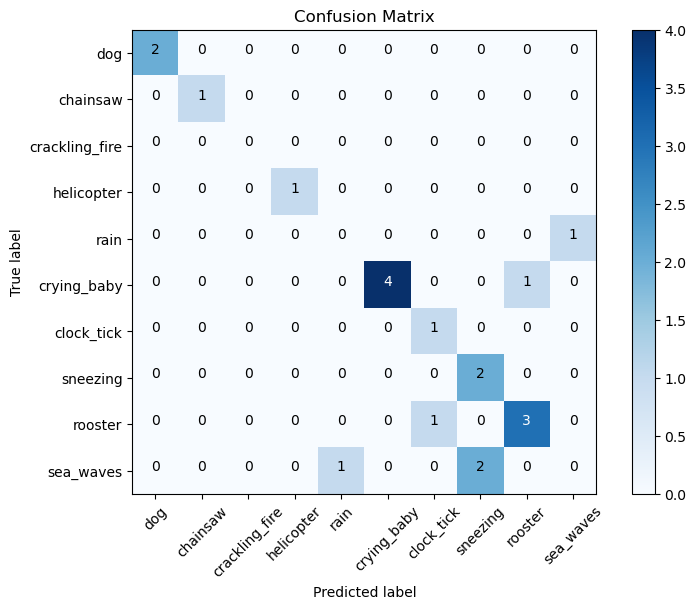

In [47]:
plot_confusion_matrix(inceptionv4, test_dataset)

## DenseNet121

### In this approach, we implement the DenseNet121 from scratch for the classification task.

### We consider the following points:

* All hidden layers use ReLu as their activation function
* The final layer uses Softmax as its activation function
* The Adam optimizer is used to minimize the gradient
* The Categorical Crossentropy is used for the loss function
* The Accuracy metric is used to evaluate model performance

In [48]:
class DenseNet121:
    def __conv_block(self, x, growth_rate):
        x1 = tf.keras.layers.BatchNormalization()(x)
        x1 = tf.keras.layers.Activation('relu')(x1)
        x1 = tf.keras.layers.Conv2D(growth_rate, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x1)
        return tf.keras.layers.concatenate([x, x1], axis=-1)
    
    def __dense_block(self, x, blocks, growth_rate):
        for _ in range(blocks):
            x = self.__conv_block(x, growth_rate)
        return x
    
    def __transition_block(self, x, reduction):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(x)
        return tf.keras.layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    
    def __DenseNet121(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4))(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = self.__dense_block(x, 6, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 12, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 24, 32)
        x = self.__transition_block(x, 0.5)

        x = self.__dense_block(x, 16, 32)

        output = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=output, name='DenseNet121')

    def create_model(self, input_shape):
        base_model = self.__DenseNet121(input_shape=input_shape)
        fc = tf.keras.layers.Dense(10, activation='softmax')(base_model.output)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='DenseNet121_Classifier')

In [49]:
densenet121 = DenseNet121().create_model(input_shape=spectrogram.shape)

In [50]:
densenet121.summary()

Model: "DenseNet121_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_154 (Conv2D)            (None, 128, 128, 64  3200        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_155 (Batch  (None, 128, 128, 64  256        ['conv2d_154[0][0]']             
 Normalization)                 )                                            

In [51]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_densenet121.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

MAX_EPOCHS = 80

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.9, max_epochs=MAX_EPOCHS, patience=2)

densenet121.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [52]:
densenet121_history = densenet121.fit(train_dataset, epochs = MAX_EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint, early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/80
22/22 [==============================] - ETA: 0s - loss: 2.3289 - accuracy: 0.3892 - precision_2: 0.6095 - recall_2: 0.1818
Epoch 1: val_accuracy improved from -inf to 0.28125, saving model to best_densenet121.h5
22/22 [==============================] - 50s 331ms/step - loss: 2.3289 - accuracy: 0.3892 - precision_2: 0.6095 - recall_2: 0.1818 - val_loss: 2.6484 - val_accuracy: 0.2812 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/80
22/22 [==============================] - ETA: 0s - loss: 1.7269 - accuracy: 0.5739 - precision_2: 0.6902 - recall_2: 0.3608
Epoch 2: val_accuracy did not improve from 0.28125
22/22 [==============================] - 5s 234ms/step - loss: 1.7269 - accuracy: 0.5739 - precision_2: 0.6902 - recall_2: 0.3608 - val_loss: 2.7041 - val_accuracy: 0.2500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/80
22/22 [==============================] - ETA: 0s - loss: 1.4384 - accuracy: 0.7500 - precision_2: 0.8197 - recall_2: 0.5

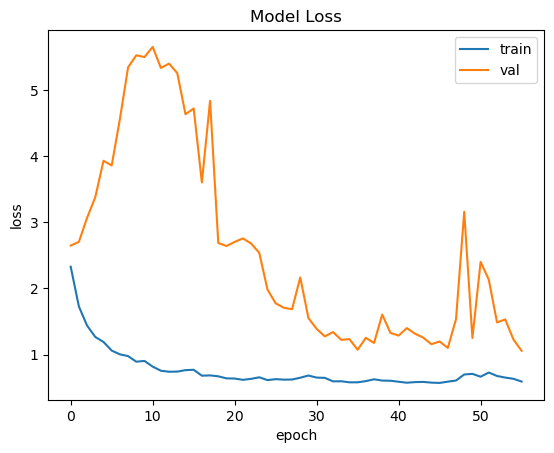

In [53]:
plot_loss_curve(densenet121_history)

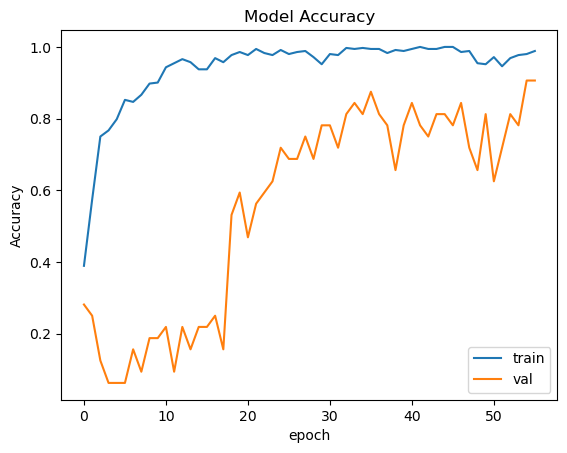

In [54]:
plot_accuracy_curve(densenet121_history)

In [55]:
densenet121_score = densenet121.evaluate(test_dataset, verbose='auto', steps=test_steps)
print("DenseNet121 classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(densenet121_score[0]))
print('Testset Accuracy = {:.2f}'.format(densenet121_score[1]))
print('Testset Precision = {:.2f}'.format(densenet121_score[2]))
print('Testset Recall = {:.2f}'.format(densenet121_score[3]))

2/2 [==============================] - 1s 489ms/step - loss: 1.2260 - accuracy: 0.8500 - precision_2: 0.8500 - recall_2: 0.8500
DenseNet121 classifier evaluation results:

Testset Loss = 1.22602
Testset Accuracy = 0.85
Testset Precision = 0.85
Testset Recall = 0.85


2/2 [==============================] - 2s 29ms/step


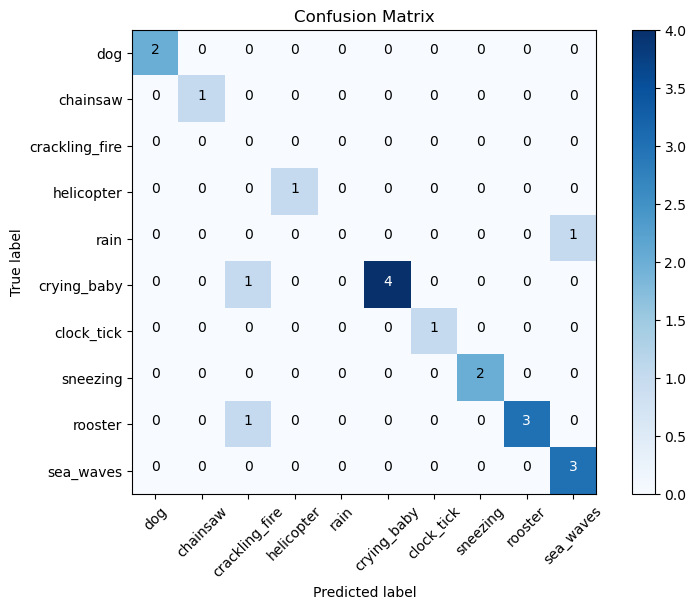

In [56]:
plot_confusion_matrix(densenet121, test_dataset)